# Evaluate a netCDF file in PODPAC

## Overview

This tutorial demonstrates how to open and explore the netCDF file, visualize the data, and export to a comma-separated file (CSV). This tutorial is intended for the users with novice-level programming skills. However, it is expected that the users familiarize themselves with key aspects of [netCDF climate and forecast (CF) metadata convention](http://cfconventions.org/cf-conventions/v1.6.0/cf-conventions.html) before starting the tutorials.

## Source Data

The source data is a netCDF file ([soil_moist_20min_Kendall_AZ_n1400.nc](https://daac.ornl.gov/daacdata/eos_land_val/SoilSCAPE/data//soil_moist_20min_Kendall_AZ_n1400.nc)) consisting of  volumetric root zone soil moisture data from a location in Kendall, Arizona, USA. This data was collected as a part of SoilSCAPE (Soil moisture Sensing Controller and oPtimal Estimator) project (https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1339)

## Prerequisites

Python 3.x or later. Python modules: netCDF4, numpy, pandas, matplotlib

## Tutorial

In this tutorial, we will open and explore the netCDF file, visualize the data, and export to a comma-separated file (CSV). 

### 1. Import python modules

First import the required modules:

In [1]:
%matplotlib inline
# above generates plots in line within this page

import pandas as pd # pandas module
import numpy as np # numpy module
import netCDF4 as nc # netcdf module
import matplotlib.pyplot as plt # plot from matplotlib module

### 2. Read and explore the netCDF file
Read in the netCDF file at folder /data/indata/ into 'in_nc'. Printing 'in_nc' displays important information about the data sets, such as *global attributes*, *data dimensions*, and *variable names*. Global attributes in a netCDF file contains information about the data such as data authors, publisher, data contacts, etc.

In [2]:
in_nc = nc.Dataset("../data/indata/soil_moist_20min_Kendall_AZ_n1400.nc") # read file
print(in_nc) # print file information

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Volumetric soil moisture data at 20 minute intervals from in-situ probes for Node ID 1400 from 20150816 to 20170803 at Kendall, AZ
    institution: Oak Ridge National Laboratory (ORNL) Distributed Active Archive Center (DAAC)
    contact: support-ornl@earthdata.nasa.gov
    project: SoilSCAPE
    site: Kendall, AZ
    source: Soil moisture observation for Node ID 1400
    comment: Soil moisture values are expressed as percentage volumetric water content, converted to m^2/m^2 divided by 100. The measurements are provided from three or more Decagon EC - 5 sensors placed at different depths below the surface, recording measurements at 20 minute intervals. Soil moisture values less than 0.1 percent are fixed at 0.1 percent and flagged (5), negative values sometimes occur due to the current calibration. Values over 60 percent are flagged (5) and set to -9999.0f. Spikes are detected if |sm[i] - m

In the above print output, we can get the variables names and dimension names/sizes. For example, "lat", "lon" variables with geographic coordinates, and "soil moisture" variable with the volumetric soil moisture data. Let us print the location:

In [3]:
y = in_nc.variables['lat'][:] # read latitutde variable
x = in_nc.variables['lon'][:] # read longitude variable
print("Latitude: %.5f, Longitude: %.5f" % (y,x)) # print latitutde, longitude

Latitude: 31.73648, Longitude: -109.94183


### 3. Read in variables and check attributes
In this step we will read in variables we are interested in and print their attributes (e.g. units of measurements, detailed names etc).

In [4]:
soil_moisture = in_nc.variables['soil_moisture'][:] # read soil moisture variable
print(in_nc.variables['soil_moisture']) # print the variable attributes

<class 'netCDF4._netCDF4.Variable'>
float32 soil_moisture(time, depth)
    _FillValue: -9999.0
    units: percent
    long_name: volumetric soil moisture
    ancillary_variables: moisture_flag
    coordinates: lat lon
unlimited dimensions: time
current shape = (33025, 3)
filling on


In [5]:
depth = in_nc.variables['depth'][:] # read depth variable
print(in_nc.variables['depth']) # print the variable attributes

<class 'netCDF4._netCDF4.Variable'>
int32 depth(depth)
    units: cm
    positive: down
    long_name: soil depth
    standard_name: depth
    valid_range: [  0 200]
unlimited dimensions: 
current shape = (3,)
filling on, default _FillValue of -2147483647 used



In [6]:
time = in_nc.variables['time'][:] # read time variable
print(in_nc.variables['time']) # print the variable attributes

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    units: minutes since 2011-01-01 00:00:00.0 UTC
    calendar: standard
    long_name: Time in minutes since 2011/01/01
    standard_name: time
unlimited dimensions: time
current shape = (33025,)
filling on, default _FillValue of 9.969209968386869e+36 used



### 4. Convert time values
As you may have noticed, the time units in most netCDFs are relative to a fixed date (e.g. minutes since 2011-01-01 in this case). To convert it to corresponding meaningful date/time values, we will use 'num2date' command:

In [7]:
time_unit = in_nc.variables["time"].getncattr('units') # first read the 'units' attributes from the variable time
time_cal = in_nc.variables["time"].getncattr('calendar') # read calendar type
local_time = nc.num2date(time, units=time_unit, calendar=time_cal) # convert time
print("Original time %s is now converted as %s" % (time[0], local_time[0])) # check conversion

Original time 2431984.38333 is now converted as 2015-08-16 21:04:23


### 5. Create daily average soil moisture plot
To create soil moisture plots aggregated by day, we will first put the data into a *pandas dataframe*, which let you organize data in a meaningful tabular data structure and does time aggregation easily.

In [8]:
sm_df = pd.DataFrame(soil_moisture, columns=depth, index=local_time.tolist()) # read into pandas dataframe
print(sm_df[:5]) # print the first 5 rows of dataframe

                        5          15     30
2015-08-16 21:04:23    NaN        NaN    NaN
2015-08-16 22:59:23  19.66  18.500000  13.51
2015-08-16 23:29:23  19.02  18.120001  13.26
2015-08-16 23:59:22  19.02  18.120001  12.87
2015-08-17 00:29:22  18.76  17.990000  12.87


Now we will convert the original (~ half-hourly) data to daily using *Pandas's TimeGrouper"*. '1D' means daily, '6M' means six-monthly etc. More aliases are listed [here](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases). Notice that we are using "numpy's nanmean" instead of "mean" to exclude all NaN values. Ignore any run time warning messages. 

In [9]:
sm_df_daily = sm_df.groupby(pd.TimeGrouper('1D')).aggregate(np.nanmean) # convert to daily.
print(sm_df_daily[:5]) # print the first 5 rows

                   5          15         30
2015-08-16  19.233334  18.246668  13.213333
2015-08-17  18.263159  18.389475  13.372106
2015-08-18  16.290640  18.332766  13.770000
2015-08-19  15.172341  17.824465  13.445956
2015-08-20  14.108541  17.430000  13.167916


/Users/rvs/.pyenv/versions/3.6.1/lib/python3.6/site-packages/pandas/core/groupby.py:842: RuntimeWarning: Mean of empty slice
  f = lambda x: func(x, *args, **kwargs)


We will now create plot of daily time series of soil moisture measured at soil depths (5, 15 and 30cm) using python's matplotlib module:

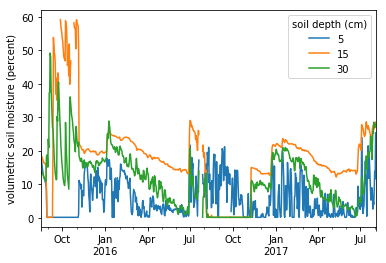

In [10]:
ylabel_name = in_nc.variables["soil_moisture"].getncattr('long_name') + ' (' + \
              in_nc.variables["soil_moisture"].getncattr('units') + ')' # Label for y-axis
series_name = in_nc.variables["depth"].getncattr('long_name') + ' (' + \
              in_nc.variables["depth"].getncattr('units') + ')' # Legend title
# plot
plt.figure()
sm_df_daily.plot()
plt.legend(title=series_name)
plt.ylabel(ylabel_name)

### 6. Output to CSV
We can also convert pandas dataframes (both daily and original) to separate comma-separated-values(CSV) files, to be used for further analysis, etc.


In [11]:
sm_df_daily.to_csv("../data/outdata/daily_soilscape.csv", index_label="DateTime") # Daily
sm_df.to_csv("../data/outdata/original_soilscape.csv", index_label="DateTime") # Original

Now that we are done with the tutorial, the netCDF dataset needs to be closed:

In [12]:
in_nc.close()